In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join
import numpy as np
from pandas.api.types import is_numeric_dtype
from common import method_aliases

In [2]:
TRAINED_MODELS_DIR = "../trained_models"
EVALS_DIR = "../evals"
METHODS = ["Autocovariance", "Augmentation Ensemble", "Representation Ensemble", "STA-LTA"]
MODELS = ["autocovariance_detector_30s", "ensemble5_cross_covariance_detector30s", "sta_lta_detector"]
METHOD_MODEL_BINDINGS = {"Autocovariance": "autocovariance_detector_30s", "Augmentation Cross-covariances":"autocovariance_detector_30s", 
                         "Representation Cross-covariances": "ensemble5_cross_covariance_detector30s", "STA-LTA": "sta_lta_detector"}

DATASETS = ["instance", "stead"]
SPLITS = [0, 1, 2, 3, 4]
METHOD_EVAL_PATHS = [f'{EVALS_DIR}/autocovariance_30s', f'{EVALS_DIR}/augmentation_ensemble_30s', f'{EVALS_DIR}/representation_ensemble_30s', f'{EVALS_DIR}/sta_lta']

In [3]:
def get_history_path(split_idx, train_dataset, model_name):
    return "{}/{}/{}/split{}/history.csv".format(TRAINED_MODELS_DIR, train_dataset, model_name, split_idx)

def map_model_names(model_name):
    mapper = {"autocovariance_detector_30s": "Autoencoder", 
              "ensemble5_cross_covariance_detector30s": "Ensemble",
              "sta_lta_detector": "STA-LTA"}
    return mapper[model_name]

def collect_evals(eval_paths):
    metric_dfs=[]
    for eval_path in eval_paths:
        metric_dfs.append(pd.read_csv(join(eval_path, 'metrics.csv')))

    df_metric = pd.concat(metric_dfs)
    df_metric.rename(mapper={"model":"Method", "training":"Training", "testing":"Testing", "auc":"ROC-AUC", "epoch":"Epoch"}, axis=1, inplace=True)
    df_metric["Method"] = df_metric["Method"].apply(lambda x: method_aliases(x))

    return df_metric

def collect_histories(models, datasets, splits):
    history_dfs = []
    for model in models:
        for dataset in datasets:
            for split in splits:
                hpath = get_history_path(split, dataset, model)
                df = pd.read_csv(hpath)
                df["Model"] = model
                df["Training"] = dataset
                df["split"] = split

                history_dfs.append(df)
    df_history = pd.concat(history_dfs)
    df_history.rename(columns={'Unnamed: 0': 'Epoch', 'val_loss':"Validation loss"}, inplace=True)
    return df_history

In [4]:
df_history = collect_histories(MODELS, DATASETS, SPLITS)
df_eval = collect_evals(METHOD_EVAL_PATHS)

# Now I want to add model column to df_eval. I can do this by using a function to map all method names to model names. 
df_eval['Model'] = df_eval['Method'].map(lambda x: METHOD_MODEL_BINDINGS[x])

# There are rows in df_eval which repeat the same method, training set, testing set and epoch. I want to assign another column which is the order of each row for each method, training set, testing set and epoch.
df_eval['split'] = df_eval.groupby(['Method', 'Training', 'Testing', 'Epoch']).cumcount()

# Elimiminate rows where the epoch is -1. This is because the epoch is -1 when the model is not trained.
df_eval = df_eval[df_eval.Epoch >= 0]
print(df_eval.isna().sum())

pre         0
rec         0
f1_score    0
Method      0
Epoch       0
split       0
Training    0
Testing     0
ROC-AUC     0
av_pre      0
Model       0
dtype: int64


In [5]:
# Now merge the history and evaluation dataframes.
df_merged = df_eval.merge(df_history, on=['Model', 'Training', 'split', 'Epoch'], how='left')
print(df_merged.isna().sum())
df_history.to_csv(join('df_history.csv'), index=False)
print(df_merged.shape)
df_merged = df_merged[['Method', 'Model', 'Training', 'Testing', 'split', 'Validation loss', 'Epoch', 'ROC-AUC']]

# From each Method, Training set and split, I want to get the model with minimum validation loss.
df_best_auc = df_merged.loc[df_merged.groupby(['Method', 'Model', 'Training', 'Testing', 'split'])['ROC-AUC'].idxmax()]
df_best_auc.to_csv(join(EVALS_DIR, 'df_best_rocauc.csv'), index=False)

# From each Method, Training set and split, I want to get the model with minimum validation loss.
df_best_val = df_merged.loc[df_merged.groupby(['Method', 'Model', 'Training', 'Testing', 'split'])['Validation loss'].idxmin()]
df_best_val.to_csv(join(EVALS_DIR, 'df_best_val.csv'), index=False)

pre                0
rec                0
f1_score           0
Method             0
Epoch              0
split              0
Training           0
Testing            0
ROC-AUC            0
av_pre             0
Model              0
loss               0
Validation loss    0
dtype: int64
(920, 13)


In [6]:
mean_rocauc = df_best_val.groupby(['Method', 'Training', 'Testing'])["ROC-AUC"].mean()
std_rocauc = df_best_val.groupby(['Method', 'Training', 'Testing'])["ROC-AUC"].std()

mean_rocauc = mean_rocauc.reset_index()
std_rocauc = std_rocauc.reset_index()

mean_rocauc = mean_rocauc.rename(columns={"ROC-AUC": "Mean ROC-AUC"})
std_rocauc = std_rocauc.rename(columns={"ROC-AUC": "Std ROC-AUC"})

df_rocauc = pd.merge(mean_rocauc, std_rocauc, on=['Method', 'Training', 'Testing'])
df_rocauc.sort_values(by=['Training', 'Testing', 'Method'], ascending=True, inplace=True)

print(df_rocauc.round(3))

                              Method  Training   Testing  Mean ROC-AUC  \
0     Augmentation Cross-covariances  instance  instance         0.970   
4                     Autocovariance  instance  instance         0.964   
8   Representation Cross-covariances  instance  instance         0.976   
12                           STA-LTA  instance  instance         0.968   
1     Augmentation Cross-covariances  instance     stead         0.974   
5                     Autocovariance  instance     stead         0.964   
9   Representation Cross-covariances  instance     stead         0.983   
13                           STA-LTA  instance     stead         0.987   
2     Augmentation Cross-covariances     stead  instance         0.973   
6                     Autocovariance     stead  instance         0.973   
10  Representation Cross-covariances     stead  instance         0.975   
14                           STA-LTA     stead  instance         0.968   
3     Augmentation Cross-covariances  

KeyError: 'Augmentation Ensemble'

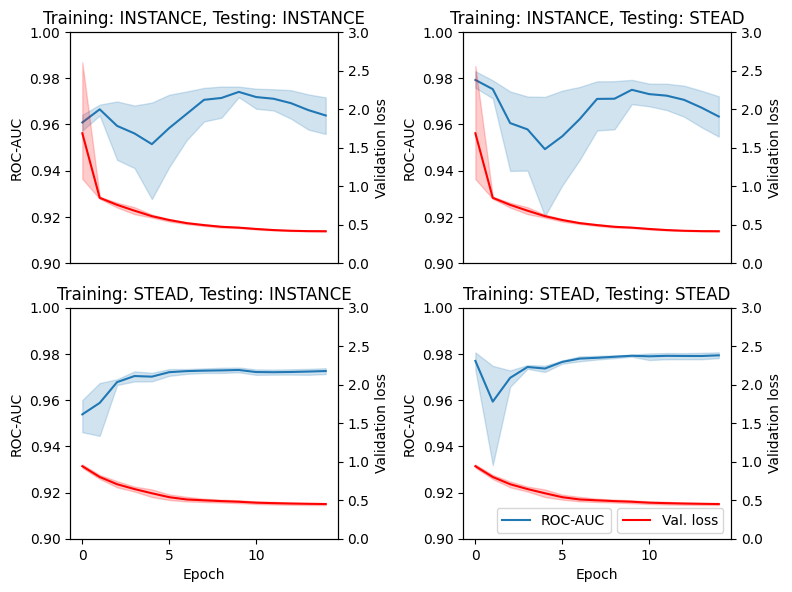

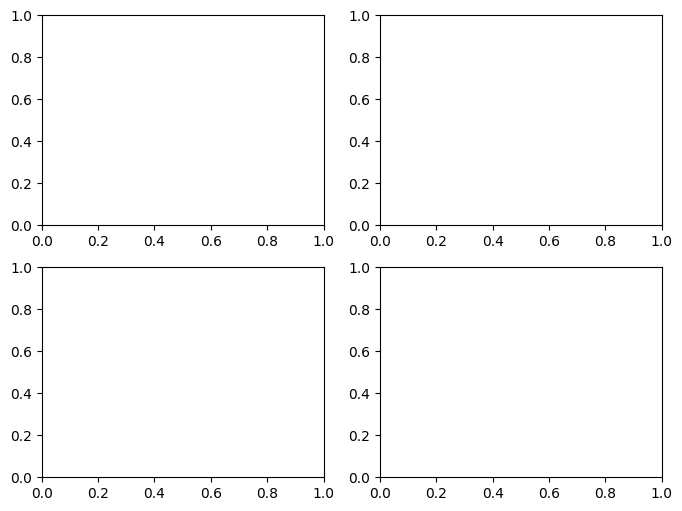

In [7]:
for method_idx, method in enumerate(METHODS):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
    for train_idx, training_set in enumerate(["instance", "stead"]):
        for test_idx, test_set in enumerate(["instance", "stead"]):
            _df_eval = df_eval[(df_eval["Training"] == training_set) & (df_eval["Testing"] == test_set)]
            _df_eval = _df_eval[_df_eval["Method"] == method]

            _df_eval = _df_eval[_df_eval.Epoch < 15]

            _df_history = df_history[df_history["Training"] == training_set]
            _df_history = _df_history[_df_history["Model"] == METHOD_MODEL_BINDINGS[method]]
            _df_history = _df_history[_df_history.Epoch < 15]

            axs[train_idx, test_idx].set_ylim(0.9, 1)
            axs[train_idx, test_idx].set_title(f"Training: {training_set.upper()}, Testing: {test_set.upper()}")
            ax_twin = axs[train_idx, test_idx].twinx()

            if METHOD_MODEL_BINDINGS[method] == "ensemble5_cross_covariance_detector30s":
                ax_twin.set_ylim(2.0, 6.0)
            else:
                ax_twin.set_ylim(0.0, 3.0)

            if train_idx == 1 and test_idx == 1:
                sns.lineplot(data=_df_eval, x='Epoch', y='ROC-AUC', hue='Method', ax=axs[train_idx, test_idx], legend=False)
                sns.lineplot(data=_df_history, x='Epoch', y='Validation loss', ax=ax_twin, color='red', legend=False)
                ax_twin.legend(["Val. loss"], loc=[0.575, 0.025])
                axs[train_idx, test_idx].legend(["ROC-AUC"], loc=[0.125, 0.025])
            else:
                sns.lineplot(data=_df_eval, x='Epoch', y='ROC-AUC', hue='Method', ax=axs[train_idx, test_idx], legend=False)
                sns.lineplot(data=_df_history, x='Epoch', y='Validation loss', ax=ax_twin, color='red', legend=False)

            if train_idx == 0:
                axs[train_idx, test_idx].get_xaxis().set_visible(False)

    plt.tight_layout(pad=1.0)
    plt.savefig('../evals/validation_loss{}.pdf'.format(method_idx), dpi=600)